In [118]:
import numpy as np
from sdeint import itoSRI2, itoEuler
import matplotlib.pyplot as plt

In [149]:
periods = 1
ppp = 10000
dt = 1/ppp
times = np.arange(0.,periods+dt,dt)

eta = 1
gamma = 0.3
Lambda = 0.8
omega = 2*np.pi
n = 10

A = np.array([[-.5*gamma, omega], [-omega, -0.5*gamma]])
D = np.diag([(gamma*(n+0.5)) + Lambda]*2)
C = np.diag([np.sqrt(4*eta*Lambda)]*2)

In [150]:
def f(t,s,parameters=None):
    x = s[0:2]
    xdot = np.dot(A,x)
    
    y = s[2:4]
    ydot = np.dot(C,x)
    
    varx, varp,covxp = s[4:]
    
    varx_dot = ((0.5 + n)*gamma) - (varx*gamma) + Lambda - (4*eta*Lambda*covxp**2)  - ((0.5+n)*gamma  + Lambda + (2*varx*np.sqrt(eta*Lambda)))**2 + (2*covxp*omega)
    varp_dot = ((0.5 + n)*gamma) - (varp*gamma) + Lambda - (4*eta*Lambda*covxp**2) -  ((0.5+n)*gamma + Lambda + (2*varp*np.sqrt(eta*Lambda)))**2 - (2*covxp*omega)
    covxp_dot = covxp*(-(4*eta*varp) - (4*varx*eta) - (4*np.sqrt(eta*Lambda))  ) + covxp*gamma*(-1 -2*np.sqrt(eta*Lambda) - (4*n*np.sqrt(eta*Lambda))) + (varp*omega - varx*omega)
        
    #varx_dot = ((0.5 + n)*gamma) + Lambda - (4*eta*Lambda*covxp**2) - ((0.5+n)*gamma + Lambda + 2*(varx)*np.sqrt(eta*Lambda) )**2 + (2*np.exp(-gamma*0.5)*varx*np.cos(omega)) + (2*covxp*np.exp(-0.5*gamma)*np.sin(omega))
    #varp_dot = ((0.5 + n)*gamma) + Lambda - (4*eta*Lambda*covxp**2) - ((0.5+n)*gamma + Lambda + 2*(varp)*np.sqrt(eta*Lambda) )**2 + (2*np.exp(-gamma*0.5)*varp*np.cos(omega)) - (2*covxp*np.exp(-0.5*gamma)*np.sin(omega))
    #covxp_dot = -4*np.exp(-gamma*0.5)*( covxp*np.exp(gamma*0.5)*((eta*Lambda*varp) + (eta*Lambda*varx) + (np.sqrt(eta*Lambda)*(0.5+n)*gamma + Lambda) )) - (0.5*covxp*np.cos(omega)) - (0.25*varp + 0.25*varx)*np.sin(omega)
    
    return np.array([xdot[0], xdot[1], ydot[0],  ydot[1], varx_dot, varp_dot, covxp_dot])



def Fs(s,t):
    x = s[0:2]
    xdot = np.dot(A,x)
    
    y = s[2:4]
    ydot = np.dot(C,x)
    
    varx, varp,covxp = s[4:]
    
    varx_dot = ((0.5 + n)*gamma) - (varx*gamma) + Lambda - (4*eta*Lambda*covxp**2)  - ((0.5+n)*gamma  + Lambda + (2*varx*np.sqrt(eta*Lambda)))**2 + (2*covxp*omega)
    varp_dot = ((0.5 + n)*gamma) - (varp*gamma) + Lambda - (4*eta*Lambda*covxp**2) -  ((0.5+n)*gamma + Lambda + (2*varp*np.sqrt(eta*Lambda)))**2 - (2*covxp*omega)
    covxp_dot = covxp*(-(4*eta*varp) - (4*varx*eta) - (4*np.sqrt(eta*Lambda))  ) + covxp*gamma*(-1 -2*np.sqrt(eta*Lambda) - (4*n*np.sqrt(eta*Lambda))) + (varp*omega - varx*omega)
        
    #varx_dot = ((0.5 + n)*gamma) + Lambda - (4*eta*Lambda*covxp**2) - ((0.5+n)*gamma + Lambda + 2*(varx)*np.sqrt(eta*Lambda) )**2 + (2*np.exp(-gamma*0.5)*varx*np.cos(omega)) + (2*covxp*np.exp(-0.5*gamma)*np.sin(omega))
    #varp_dot = ((0.5 + n)*gamma) + Lambda - (4*eta*Lambda*covxp**2) - ((0.5+n)*gamma + Lambda + 2*(varp)*np.sqrt(eta*Lambda) )**2 + (2*np.exp(-gamma*0.5)*varp*np.cos(omega)) - (2*covxp*np.exp(-0.5*gamma)*np.sin(omega))
    #covxp_dot = -4*np.exp(-gamma*0.5)*( covxp*np.exp(gamma*0.5)*((eta*Lambda*varp) + (eta*Lambda*varx) + (np.sqrt(eta*Lambda)*(0.5+n)*gamma + Lambda) )) - (0.5*covxp*np.cos(omega)) - (0.25*varp + 0.25*varx)*np.sin(omega)
    
    return np.array([xdot[0], xdot[1], ydot[0],  ydot[1], varx_dot, varp_dot, covxp_dot])


def s_to_cov(s,begin_cov=4):
    varx, varp,covxy = s[begin_cov:]
    cov = np.array([[varx, covxy], [covxy, varp]])
    return cov


def Gs(s,t):
    cov = s_to_cov(s)
    XiCov = np.dot(cov, C.T) + D.T
    wieners = np.zeros((s.shape[0], s.shape[0]))
    wieners[:2,:2]  = XiCov
    wieners[2:4,2:4] = np.eye(2)
    return wieners

In [151]:
x0 = 0.
p0 = 0.
yx0 = 0.
yp0 = 0.
varx0 = 1.
varp0 = 1.
covxy0 = 0.
s0 = np.array([x0, p0, yx0, yp0, varx0, varp0,covxy0])
np.random.seed(1)

In [152]:
ss = itoSRI2(Fs,Gs,s0,times)
ssE = itoEuler(Fs,Gs,s0,times)

In [154]:
states = ss[:,0:2]
statesE = ssE[:,0:2]

signals = ss[:,2:4]
signals = signals[1:] - signals[:-1]

signalsE = ssE[:,2:4]
signalsE = signalsE[1:] - signalsE[:-1]


covss = ss[:,-3:]
covs = [s_to_cov(s,begin_cov=0) for s in covss]

covssE = ss[:,-3:]
covsE = [s_to_cov(s,begin_cov=0) for s in covssE]

Comparing with data obtained with another implementation (integrate Ricatti eq for covariance...)

In [155]:
diffs = states[1:]-states[:-1]
invsXiCov = np.array([np.linalg.inv(xi(cov,D)) for cov in covs[:-1]])
CAx = np.einsum('ij,bj->bi',C-A,states[:-1])*dt
signalss = np.einsum('bij,bj->bi',invsXiCov,CAx + diffs)

In [156]:
diffsE = statesE[1:]-statesE[:-1]
invsXiCov = np.array([np.linalg.inv(xi(cov,D)) for cov in covsE[:-1]])
CAx = np.einsum('ij,bj->bi',C-A,statesE[:-1])*dt
signalssE = np.einsum('bij,bj->bi',invsXiCov,CAx + diffsE)

Now let's check the Euler using the dy's

In [161]:
from tqdm import tqdm
from misc import ct
xi = lambda cov,D: np.dot(cov, ct(C)) + ct(D)

ExpA = np.array([[np.cos(omega*dt), -np.sin(omega*dt)], [np.sin(omega*dt), np.cos(omega*dt)]])*np.exp(-gamma*dt/2)

def evolve_simu_state(x, sigma, dy):
    cov = sigma
    XiCov = xi(cov, D)
    dx = np.dot(A-np.dot(XiCov,C),x)*dt   + np.dot(XiCov,dy)# np.dot(ExpA-np.eye(2), x) - np.dot(np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov]

sstates = [statesE[0]]
scovs = [covsE[0]]

for ind,dy in enumerate(tqdm(signalss)):
    simu = evolve_simu_state(sstates[-1],scovs[-1], dy)
    sstates.append(simu[0])
    scovs.append(simu[1])#[ind+1])

100%|██████████| 10000/10000 [00:00<00:00, 38935.29it/s]


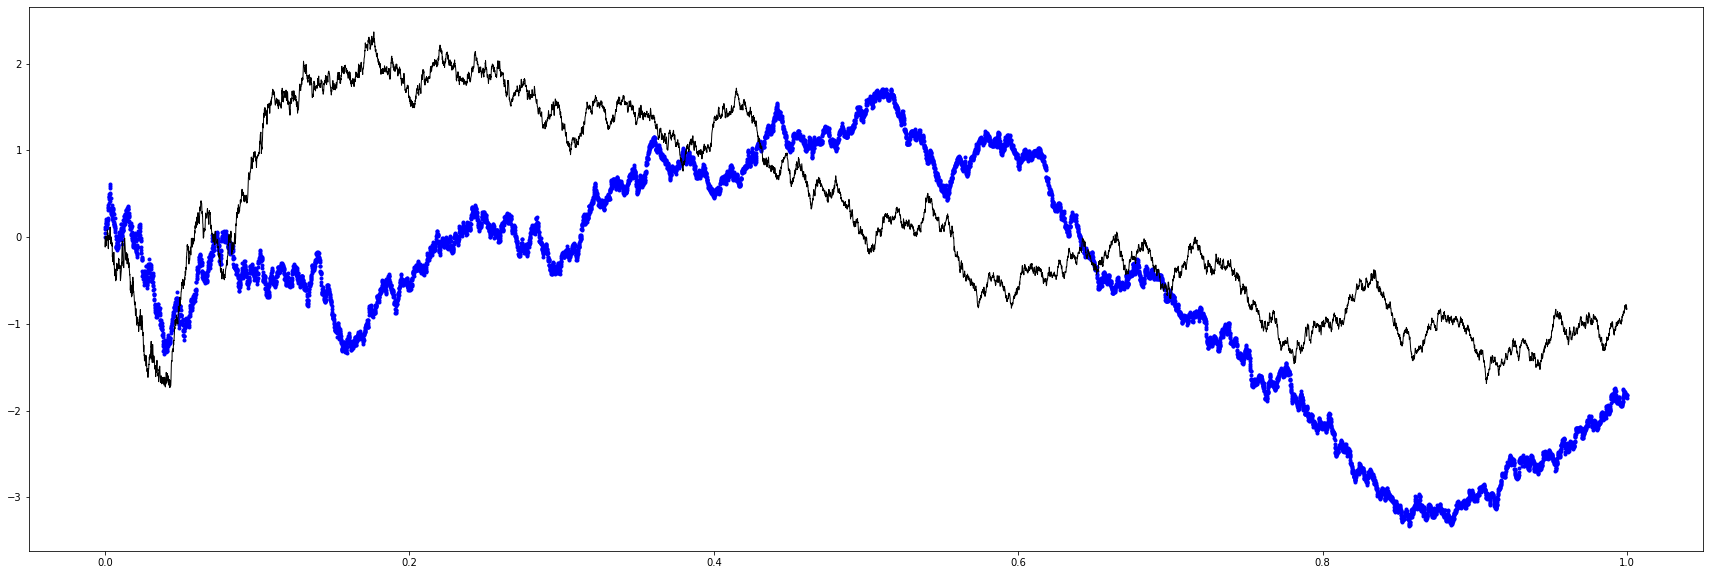

In [162]:
plt.figure(figsize=(30,10))
T=-1
plt.plot(times[:T],np.array(sstates)[:,0][:T], '.',color="blue")
plt.plot(times[:T],statesE[:,0][:T],color="black", linewidth=1)

0.0001

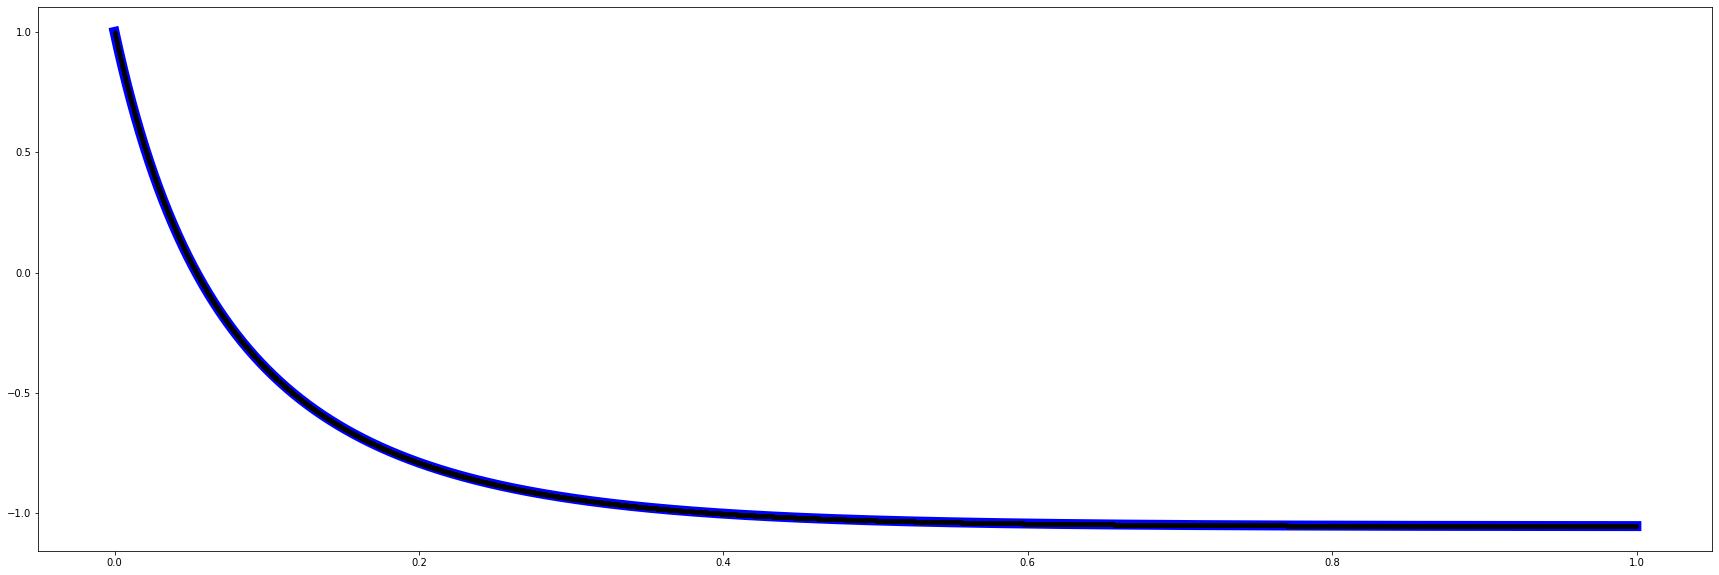

In [146]:
plt.figure(figsize=(30,10))
T=-1
plt.plot(times[:T],np.array(covsE)[:,0,0][:T], '-', linewidth=10,color="blue",)
plt.plot(times[:T],np.array(scovs)[:,0,0][:T],'.',color="black", linewidth=4)

In [293]:
np.sum(np.square(np.array(signals) - np.einsum('ij,bj->bi',C,np.array(states)[:-1])*dt))/2

0.9941824354811466

In [294]:
np.sum(np.square(np.array(signals) - np.einsum('ij,bj->bi',C,np.array(sstates)[:-1])*dt))/2

0.9989240300489907

In [303]:
reconstructed_noises = signals - np.einsum('ij,bj->bi',C,np.array(sstates)[:-1])*dt
reconstructed_signal = np.einsum('ij,bj->bi',C,np.array(sstates)[:-1])*dt + reconstructed_noises

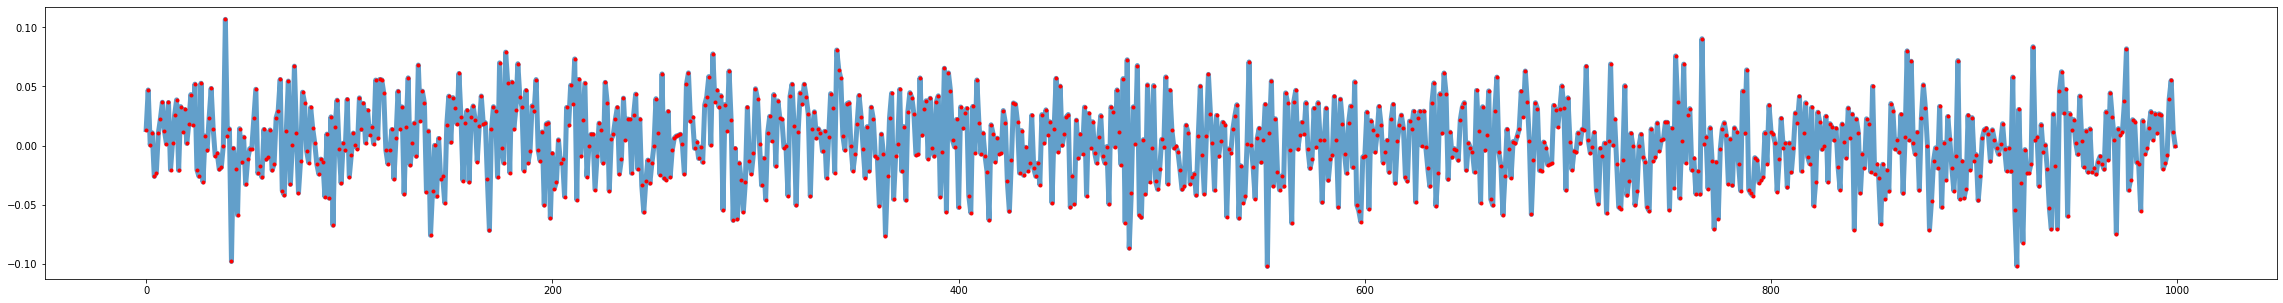

In [309]:
plt.figure(figsize=(40,5))
plt.plot(reconstructed_signal[:,0], alpha=0.7, linewidth=5)
plt.plot(np.array(signals)[:,0],'.',color="red")